In [155]:
import IPython.display as display
import librosa
import librosa.display
import numpy as np
from sklearn.utils import shuffle
from seglearn.transform import Segment
from scipy.fft import dct , idct
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
sample_audio ='the_godfather_theme_instru_mix.wav'
x,sr = librosa.load(sample_audio,sr =44100)

# Training Data

In [204]:
x1=x[:sr*30]
x2=x[sr*30:sr*60]
X=np.stack((x1,x2))
y=np.array([0,1])

In [205]:
samples_per_frame = int(sr *0.02)

In [206]:
ts = Segment(width = samples_per_frame,overlap =0).fit(X,y)
s_d = ts.transform(X,y)
print(f'Size of each vector is given by {(np.shape(s_d[0][0,:]))}')

Size of each vector is given by (882,)


In [207]:
X_d=dct(s_d[0])
print(f'Size of DCT generated feature vector is {np.shape(X_d[0,:])}')

Size of DCT generated feature vector is (882,)


In [208]:
x_train,y_train=X_d,s_d[1]
x_train,y_train=shuffle(x_train,y_train,random_state=0)
np.shape(X_d)

(3000, 882)

In [209]:
def pca(X):
    x_mean= np.mean(X,axis=0)
    xd= X-x_mean
    corr= (np.transpose(xd)@xd)/xd.shape[0]
    e,ev= np.linalg.eig(corr)
    idx = e.argsort()[::-1]   
    Eg = e[idx]
    ev = ev[:,idx]
    k=0
    err=0
    for i in range(len(e)):
        err=err+e[i]
        k+=1
        if(err>=0.99*np.sum(e)):
            break
        
    y= np.transpose(ev[:,0:k])@np.transpose(xd)
    Y= np.transpose(y)
    
    return Y

In [210]:
def bayesparameters(X):
    x_mean= np.mean(X,axis=0)
    xx= X-x_mean
    corr= (np.transpose(xx)@xx)/xx.shape[0]
    detcorr= np.linalg.det(corr)
    mean= x_mean
    corrinv= np.linalg.inv(corr)
    
    return mean, corrinv , detcorr,corr

In [211]:
def classification(x,y_train):
    c0=[]
    c1=[]
    for i in range(y_train.shape[0]):
        if y_train[i]==0:
            c0.append(x[i])
        else:
            c1.append(x[i])
    c0=np.array(c0)
    c1=np.array(c1)
    return c0,c1

In [212]:
def bayes_classifiertrain(x_train,y_train):
    # Compute the class-conditional likelihoods
    Yh=pca(x_train)
    c0,c1=classification(Yh,y_train)
    mc0,ic0,dc0,cv0= bayesparameters(c0)
    mc1,ic1,dc1,cv1= bayesparameters(c1)
    Y_label=[]
    for i in (Yh):
        
        c = np.matmul(np.transpose((i-mc0)),ic0)
        c = np.matmul(c,(i-mc0))
        d = np.matmul(np.transpose((i-mc1)),ic1)
        d = np.matmul(d,(i-mc1))
        p_x=((np.exp(-0.5*c)/dc0)+(np.exp(-0.5*d)/dc1))*0.5
        print(f'Evidence(p(x)) is {p_x}')
        pl0=np.exp(-0.5*c)/dc0
        pl1=np.exp(-0.5*d)/dc1
        print(f'Likelihood for class 0 and class 1 are {pl0},{pl1}')
        class_0_posterior = (np.exp(-0.5*c)/dc0)/((np.exp(-0.5*c)/dc0)+(np.exp(-0.5*d)/dc1))
        class_1_posterior = (np.exp(-0.5*d)/dc1)/((np.exp(-0.5*c)/dc0)+(np.exp(-0.5*d)/dc1))
        print(f'posterior probability of class0 and class1 for the sample are {class_0_posterior},{class_1_posterior}')
        # Assign the observation to the class with the highest posterior probability
        if class_0_posterior > class_1_posterior:
            Y_label.append(0)
        else:
            Y_label.append(1)
    return Y_label

In [213]:
ylabel=bayes_classifiertrain(x_train,y_train)
e=(abs(ylabel-y_train))
err=np.sum(e)
v=0
u=0
for i in range(3000):
    if y_train[i]==1:
        u+=1
    else:
        v+=1

Evidence(p(x)) is 1.0673192282386042e-159
Likelihood for class 0 and class 1 are 2.1346384564772084e-159,1.2785361005928836e-262
posterior probability of class0 and class1 for the sample are 1.0,5.989473752397633e-104
Evidence(p(x)) is 2.0390788272854103e-216
Likelihood for class 0 and class 1 are 4.0781576545708206e-216,0.0
posterior probability of class0 and class1 for the sample are 1.0,0.0
Evidence(p(x)) is 2.0250525682813416e-101
Likelihood for class 0 and class 1 are 1.412381953727244e-162,4.050105136562683e-101
posterior probability of class0 and class1 for the sample are 3.4872723203574166e-62,1.0
Evidence(p(x)) is 1.363984700372248e-103
Likelihood for class 0 and class 1 are 2.1244153363505236e-166,2.727969400744496e-103
posterior probability of class0 and class1 for the sample are 7.787533598326817e-64,1.0
Evidence(p(x)) is 2.6584184629113547e-106
Likelihood for class 0 and class 1 are 1.754264881692374e-162,5.316836925822709e-106
posterior probability of class0 and class1 fo

# Shape of Mean vectors and Covariance matrices

In [214]:
Yh=pca(x_train)
c0,c1=classification(Yh,y_train)
mc0,ic0,dc0,cv0= bayesparameters(c0)
mc1,ic1,dc1,cv1= bayesparameters(c1)
print(f'The shape of Means of Class 0 and Class 1 are {np.shape(mc0)},{np.shape(mc1)}')
print(f'The shape of Covariance matrices of class 0 and class 1 are {np.shape(cv0)},{np.shape(cv1)}')

The shape of Means of Class 0 and Class 1 are (73,),(73,)
The shape of Covariance matrices of class 0 and class 1 are (73, 73),(73, 73)


# Accuracy

In [215]:
accuracy=(1-(err/3000))*100
print(f'Accuracy for training data is {accuracy}')

Accuracy for training data is 92.7


In [216]:
print('Class 0 Probability is 0.5 , Class 1 probability is 0.5')

Class 0 Probability is 0.5 , Class 1 probability is 0.5


In [217]:
def pcadatavisualization(X,k,Ev):
    return np.transpose(Ev[:,0:k])@X.T

# 2D Visualization of Generated dataset

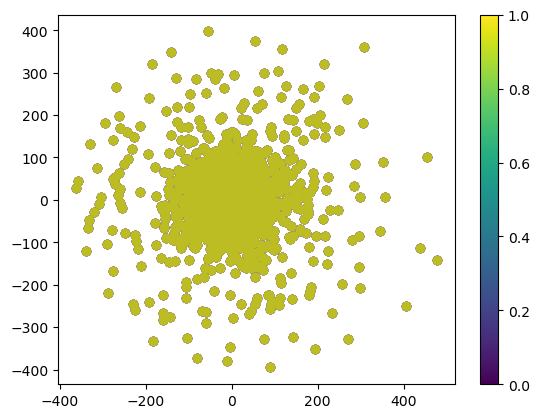

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [218]:
e,ee=np.linalg.eig((X_d.T)@X_d)
Yh=pcadatavisualization(x_train,2,ee)
plt.scatter(Yh[0, :], Yh[1, :])
#plt.colorbar()
plt.show()

# Classification of original signal vectors 

In [219]:
x_to,y_to=s_d[0],s_d[1]
x_to,y_to=shuffle(x_to,y_to,random_state=0)
np.shape(s_d[0])

(3000, 882)

In [220]:
ylabel=bayes_classifiertrain(x_to,y_to)
e=(abs(ylabel-y_to))
err=np.sum(e)

Evidence(p(x)) is 2.801529879591846e+78
Likelihood for class 0 and class 1 are 5.603059759183692e+78,6.37962605471768e-25
posterior probability of class0 and class1 for the sample are 1.0,1.1385968254686482e-103
Evidence(p(x)) is 3.7730843265439047e+21
Likelihood for class 0 and class 1 are 7.546168653087809e+21,0.0
posterior probability of class0 and class1 for the sample are 1.0,0.0
Evidence(p(x)) is 4.2249145614372614e+136
Likelihood for class 0 and class 1 are 2.62553129891336e+75,8.449829122874523e+136
posterior probability of class0 and class1 for the sample are 3.1072004661085833e-62,1.0
Evidence(p(x)) is 2.783693491189729e+134
Likelihood for class 0 and class 1 are 3.9973979704589827e+71,5.567386982379458e+134
posterior probability of class0 and class1 for the sample are 7.18002535679768e-64,1.0
Evidence(p(x)) is 5.354804800340105e+131
Likelihood for class 0 and class 1 are 4.024547379624674e+75,1.070960960068021e+132
posterior probability of class0 and class1 for the sample ar

# Accuracy of original signal vectors

In [221]:
accuracy=(1-(err/3000))*100
print(f'Accuracy for training data is {accuracy}')

Accuracy for training data is 92.76666666666667


# TEST DATA

In [222]:
test_audio='the_godfather_theme_test.wav'
xt,srt=librosa.load(test_audio,sr =44100)

In [223]:
xt1=xt[:sr*15]
xt2=xt[sr*15:sr*30]
Xtnew=np.stack((xt1,xt2))
yt=np.array([0,1])

In [224]:
spf=int(srt*0.02)

In [225]:
tst=Segment(width=spf,overlap =0).fit(Xtnew,yt)
s_dt=tst.transform(Xtnew,yt)
print(f'Size of each vector is given by {(np.shape(s_dt[0][0,:]))}')

Size of each vector is given by (882,)


In [226]:
X_dt=dct(s_dt[0])
print(f'Size of DCT generated feature vector is {np.shape(X_dt[0,:])}')

Size of DCT generated feature vector is (882,)


In [227]:
x_t,y_t=X_dt,s_dt[1]
x_t,y_t=shuffle(x_t,y_t,random_state=0)
np.shape(y_t)

(1500,)

In [228]:
def bayes_classifiert(X,mc0,mc1,cv0,cv1):
    # Compute the class-conditional likelihoods
    
    Y_label=[]
    dc0=np.linalg.det(cv0)
    dc1=np.linalg.det(cv1)
    ic0=np.linalg.inv(cv0)
    ic1=np.linalg.inv(cv1)
    for i in range(1500):
        c = np.matmul(np.transpose((X[:,i]-mc0)),ic0)
        c = np.matmul(c,(X[:,i]-mc0))
        d = np.matmul(np.transpose((X[:,i]-mc1)),ic1)
        d = np.matmul(d,(X[:,i]-mc1))
        p_x=((np.exp(-0.5*c)/dc0)+(np.exp(-0.5*d)/dc1))*0.5
        pl0=np.exp(-0.5*c)/dc0
        pl1=np.exp(-0.5*d)/dc1
        print(f'Likelihood for class 0 and class 1 are {pl0},{pl1}')
        print(f'Evidence is {p_x}')
        class_0_posterior = (np.exp(-0.5*c)/dc0)/((np.exp(-0.5*c)/dc0)+(np.exp(-0.5*d)/dc1))
        class_1_posterior = (np.exp(-0.5*d)/dc1)/((np.exp(-0.5*c)/dc0)+(np.exp(-0.5*d)/dc1))
        print(f'posterior probability of class0 and class1 for the sample are {class_0_posterior},{class_1_posterior}')
        # Assign the observation to the class with the highest posterior probability
        if class_0_posterior > class_1_posterior:
            Y_label.append(0)
        else:
            Y_label.append(1)
    return Y_label

In [229]:
def pca1(X,k,Ev):
    return np.transpose(Ev[:,0:k])@X.T

In [230]:
mc0 = np.mean(X_train[Y_train == 0], axis=0)
mc1 = np.mean(X_train[Y_train == 1], axis=0)
cv0=np.cov((X_train[Y_train == 0]).T)
cv1=np.cov((X_train[Y_train == 1]).T)

In [231]:
RXt=np.cov(X_dt.T)
E,Ev=np.linalg.eig(RXt)
idx=E.argsort()[::-1]
E = E[idx]
Ev = Ev[:,idx]
k=0
for i in range(len(E)):
        err=err+E[i]
        k+=1
        if(err>=0.99*np.sum(E)):
            break
Yhh=pca1(X_dt,k,Ev)

ytestlabel=bayes_classifiert(Yhh,mc0[0:59],mc1[0:59],cv0[0:59,0:59],cv1[0:59,0:59])

Likelihood for class 0 and class 1 are 1.21025791605005e-127,3.524728865750437e-126
Evidence is 1.822877328677721e-126
posterior probability of class0 and class1 for the sample are 0.03319636206480079,0.9668036379351992
Likelihood for class 0 and class 1 are 2.885682894380946e-128,1.014910215406752e-126
Evidence is 5.2188352217528075e-127
posterior probability of class0 and class1 for the sample are 0.027646809793428918,0.9723531902065711
Likelihood for class 0 and class 1 are 6.643374623281602e-129,1.5993959320855143e-127
Evidence is 8.329148391591651e-128
posterior probability of class0 and class1 for the sample are 0.03988027533516,0.96011972466484
Likelihood for class 0 and class 1 are 6.030595261820784e-129,1.2326236026084915e-127
Evidence is 6.464647776133497e-128
posterior probability of class0 and class1 for the sample are 0.04664287576567459,0.9533571242343254
Likelihood for class 0 and class 1 are 6.510913643624526e-129,2.770287638568348e-127
Evidence is 1.4176983875022967e-1

In [232]:
er=abs(ytestlabel-y_t)
error=np.sum(er)

In [233]:
print('class 0 probability is 0.5 and class 1 probability is 0.5')

class 0 probability is 0.5 and class 1 probability is 0.5


# Accuracy

In [234]:
print(f'accuracy for training data is {(1-(error/1500))*100}')

accuracy for training data is 49.26666666666667


# Classification for Original signal vectors

In [235]:
x_tso,y_tso=s_dt[0],s_dt[1]
x_tso,y_tso=shuffle(x_tso,y_tso,random_state=0)
np.shape(s_dt[0])

(1500, 882)

In [236]:
RXt=np.cov(s_dt[0].T)
s,sv=np.linalg.eig(RXt)
idx=s.argsort()[::-1]
s = s[idx]
sv = sv[:,idx]
m=0
for i in range(len(s)):
        err=err+s[i]
        m+=1
        if(err>=0.99*np.sum(s)):
            break
Yhhh=pca1(s_dt[0],m,sv)
ytestsig=bayes_classifiert(Yhhh,mc0[0:59],mc1[0:59],cv0[0:59,0:59],cv1[0:59,0:59])

Likelihood for class 0 and class 1 are 4.6834038555144485e-125,3.104686582845865e-123
Evidence is 1.575760310700505e-123
posterior probability of class0 and class1 for the sample are 0.014860774902473712,0.9851392250975262
Likelihood for class 0 and class 1 are 6.218235775448609e-125,4.1862600567646266e-123
Evidence is 2.1242212072595564e-123
posterior probability of class0 and class1 for the sample are 0.014636507144824886,0.9853634928551751
Likelihood for class 0 and class 1 are 5.10679886927632e-125,3.241165818764051e-123
Evidence is 1.6461169037284073e-123
posterior probability of class0 and class1 for the sample are 0.015511653084023278,0.9844883469159768
Likelihood for class 0 and class 1 are 5.29633185755339e-125,3.556988808469794e-123
Evidence is 1.804976063522664e-123
posterior probability of class0 and class1 for the sample are 0.014671473945246828,0.9853285260547532
Likelihood for class 0 and class 1 are 3.24821132662187e-125,1.8684892230850835e-123
Evidence is 9.50485668175

In [237]:
er=abs(ytestsig-y_tso)
error=np.sum(er)

# Accuracy for original signal vectors 

In [238]:
print(f'accuracy for training data is {(1-(error/1500))*100}')

accuracy for training data is 50.06666666666666
